In [ ]:
# default_exp plot

# GraphPed

> A pedigree visualization tool based on dot format and visualized by graphviz 

In [ ]:
#hide
from nbdev.showdoc import *

https://h1ros.github.io/posts/introduction-to-graphviz-in-jupyter-notebook/

In [ ]:
#export
import yaml
import numpy as np
import pandas as pd
from graphviz import Digraph
from IPython import display

In [ ]:
#export
def get_args():
    import argparse
    parser = argparse.ArgumentParser(description="Just an example",
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("-p", "--ped", help="ped file")
    parser.add_argument("-o", "--output", default='./',help="output folder")
    parser.add_argument("-f", "--format", help="the format of the output picture")
    parser.add_argument("-a", "--attributes", help="the attributes of the output picture")
    parser.add_argument("-e", "--engine", default='dot', help="the engine of graphviz rendering the output picture")
    return parser

def GraphPedCli():
    #test command line
    #args = get_args().parse_args('-p data/fam.ped -f svg'.split())
    if args.attributes:
        attrs=load_yaml(args.attributes)
    else:
        attrs=None
    ped=readped(args.ped,attrs)
    GraphPed(ped,attrs,args.output,args.format,args.engine)
    

def GraphPed(ped,attrs=None,output=None,fmt='svg',engine='dot'):
    fids=ped.fid.unique()
    dots=[]
    for i in fids:
        dots.append(plotped(ped[ped.fid ==i],attrs,output,fmt,engine))
    return dots

def readped(file,attrs=None):
    ''' the number of traits in the input file should match with the number of traits in the attribute yaml file'''
    if attrs:
        peds = pd.read_csv(file,header=None,names=['fid','iid','fathid','mothid','sex']+list(attrs.keys()),sep='\t')
    else:
        peds = pd.read_csv(file,header=None,names=['fid','iid','fathid','mothid','sex','trait'],sep='\t')
    return peds

def load_yaml(yaml_file):
    with open(yaml_file, "r") as stream:
        try:
            yml = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return yml

def show(dot):
    if isinstance(dot,list):
        for d in dot:
            display.display(d)
    else:
        display.display(dot)

In [ ]:
attrs=load_yaml('data/default.yaml')

In [ ]:
attrs

{'trait1': {'fillcolor': {1: 'white', 2: 'dimgrey', -9: 'aquamarine3'}},
 'trait2': {'style': {True: 'filled,setlinewidth(4)', False: 'filled'}},
 'trait3': {'fontcolor': {True: 'darkorange', False: 'black'}}}

In [ ]:
attrs.keys()

dict_keys(['trait1', 'trait2', 'trait3'])

In [ ]:
attrs.values

In [ ]:
fam=readped('data/example_fam.ped')

In [ ]:
famext=readped('data/example_fam_ext.ped',attrs)

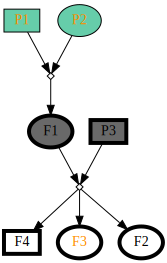

In [ ]:
plotped(famext,attrs)

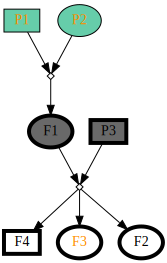

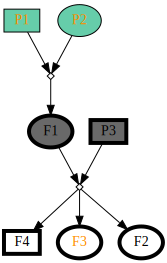

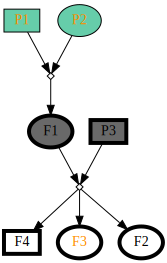

In [ ]:
for i in [a,a,a]:
    display.display(i)

In [ ]:
a.render()

'Digraph.gv.pdf'

In [ ]:
for k,v in attrs.items():
    print(k,v)

trait1 {'fillcolor': {1: 'white', 2: 'dimgrey', -9: 'aquamarine3'}}
trait2 {'style': {True: 'filled,setlinewidth(4)', False: 'filled'}}
trait3 {'fontcolor': {True: 'darkorange', False: 'black'}}


In [ ]:
for k,v in r[4:].items():
    print(k,v)

sex 2
ad -9
vcf False
depth 1
trim False


In [ ]:
#export
def update_attributes(r,attrs=None):
    #The basic attributes of a node
    attributes={'shape':'polygon','height':'0.3','width':'0.5','regular':'0','style':"filled",'fontcolor':'black'}
    gender = {"m":"box","1":"box",1:"box","f":"ellipse","2":"ellipse",2:"ellipse",0:"polygon"}
    if attrs:
        attributes['shape'] = gender[r.sex]
        for k,v in r[5:].items(): #start from gender to traits
            attr=attrs[k]
            for a,t in attr.items():
                attributes[a] = t[v]
    else:
        trait = {1:'white',2:'dimgrey',-9:'aquamarine3'}
        vcf = {True:"filled,setlinewidth(4)",False:"filled"}
        trim = {True:'darkorange',False:'black'}
        attributes['shape'] = gender[r.sex]
        #traits
        attributes['fillcolor']=trait[r.trait]
        try:
            attributes['style']=vcf[r.vcf]
            attributes['fontcolor'] = trim[r.trim]
        except:
            pass
    return attributes

def plotped(fi,attrs=None,output=None,format='svg',engine='dot'):
    #nodes
    #create iid nodes
    #create parent nodes
    #edges
    #parent to iid
    #fathid,mothid to parent
    # Create Digraph object
    dot = Digraph()
    dot.engine = engine
    # Add nodes
    parents = []
    for i,r in fi.iterrows():
        dot.node(r.iid,shape='box',_attributes=update_attributes(r,attrs))
        if r.fathid !='0' and r.mothid !='0':
            parents.append(r.fathid+'x'+r.mothid)
            dot.edge(r.fathid+'x'+r.mothid,r.iid)
        #edge to children
        ch_r = (fi.fathid==r.iid) | (fi.mothid==r.iid)
        if ch_r.any():
            for p in fi[ch_r][['fathid','mothid']].agg('x'.join, axis=1).unique():
                dot.edge(r.iid,p)
    for p in set(parents):
        dot.node(p,shape='diamond',label='',height='.1',width='.1')
    if output:
        dot.render(outfile=output+'/'+str(list(fi.fid)[0])+'.'+format,format=format,overwrite_source=True)
    else:
        return dot

In [ ]:
ped = pd.read_csv('../../SEQpy3/data/nodp_ped_with_depth_trim.csv',header=0,index_col=None)

In [ ]:
tmp=ped[ped.fid=='1036']

In [ ]:
Fam	F4	P3	F1	1	1
Fam	F3	P3	F1	2	1
Fam	F2	P3	F1	2	1
Fam	F1	P1	P2	2	2
Fam	P3	0	0	1	2
Fam	P1	0	0	1	-9
Fam	P2	0	0	2	-9

In [ ]:
fam

,fid,iid,fathid,mothid,sex,trait
0,Fam,F4,P3,F1,1,1
1,Fam,F3,P3,F1,2,1
2,Fam,F2,P3,F1,2,1
3,Fam,F1,P1,P2,2,2
4,Fam,P3,0,0,1,2
5,Fam,P1,0,0,1,-9
6,Fam,P2,0,0,2,-9


In [ ]:
tmp.index=range(tmp.shape[0])

In [ ]:
pd.concat([fam,tmp.loc[:,['vcf','trim']]],axis=1).to_csv('data/example_fam_ext.ped',header=False,index=False,sep='\t')

In [ ]:
ped[ped.fid=='10R_R99']

,fid,iid,fathid,mothid,sex,ad,vcf,depth,trim
18065,10R_R99,10R_R99_10,10R_R99_2,10R_R99_1,2,1,True,3,False
18066,10R_R99,10R_R99_19,10R_R99_2,10R_R99_1,1,1,True,3,False
18067,10R_R99,10R_R99_20,10R_R99_2,10R_R99_1,1,1,False,3,False
18068,10R_R99,10R_R99_21,10R_R99_2,10R_R99_1,1,1,False,3,False
18069,10R_R99,10R_R99_17,10R_R99_29,10R_R99_15,1,1,True,3,False
18070,10R_R99,10R_R99_22,10R_R99_29,10R_R99_15,1,1,False,3,False
18071,10R_R99,10R_R99_15,10R_R99_8,10R_R99_7,2,2,True,2,False
18072,10R_R99,10R_R99_12,10R_R99_8,10R_R99_7,2,2,True,2,False
18073,10R_R99,10R_R99_1,10R_R99_8,10R_R99_7,2,2,True,2,False
18074,10R_R99,10R_R99_5,10R_R99_8,10R_R99_7,1,1,True,2,False


In [ ]:
new_twom_fam = pd.read_csv('../../SEQpy3/data/new_twoormore_member_fam.csv',header=None,names=['fid','iid','fathid','mothid','sex','ad','vcf'])

In [ ]:
new_twom_fam

,fid,iid,fathid,mothid,sex,ad,vcf
0,4_364,4_364_99,4_364_1,4_364_2,2,2,True
1,4_44,4_44_3,4_44_1,4_44_2,2,2,True
2,27_104,27_104_62571,27_104_84753,27_104_84752,1,2,True
3,27_90,27_90_84583,27_90_84575,27_90_84574,2,2,True
4,27_90,27_90_84784,27_90_84575,27_90_84574,2,2,True
...,...,...,...,...,...,...,...
19101,27_119,27_119_86892,0,0,2,-9,False
19102,27_192,27_192_86089,0,0,2,-9,False
19103,10R_R1,10R_R1_20,0,0,2,-9,False
19104,10R_R57,10R_R57_R15,0,0,2,-9,False


In [ ]:
all_fam = pd.read_csv('../../SEQpy3/data/all_sample.fam',delim_whitespace=True,header=None,names=['fid','iid','fathid','mothid','sex','ad'])

In [ ]:
all_fam

,fid,iid,fathid,mothid,sex,ad
0,4_364,4_364_99,4_364_1,4_364_2,2,2
1,4_44,4_44_3,4_44_1,4_44_2,2,2
2,27_104,27_104_62571,27_104_84753,27_104_84752,1,2
3,27_90,27_90_84583,27_90_84575,27_90_84574,2,2
4,27_90,27_90_84784,27_90_84575,27_90_84574,2,2
...,...,...,...,...,...,...
19324,26_CJE,26_CJE_CJE43421,0,26_CJE_CJE43406,1,-9
19325,26_CBL,26_CBL_CBL12416,26_CBL_CBL12403,0,2,-9
19326,26_ARH,26_ARH_ARH05007,0,26_ARH_ARH05004,2,-9
19327,26_RBR,26_RBR_RBR22809,26_RBR_RBR22801,0,2,-9


In [ ]:
fam17 = pd.read_csv('../../SEQpy3/data/all_ped_original.fam',delim_whitespace=True,header=None,names=['fid','iid','fathid','mothid','sex','ad'])

In [ ]:
fam17

,fid,iid,fathid,mothid,sex,ad
0,1005,1005_10,1005_8,1005_99,1,-9
1,1005,1005_99,1005_1,1005_2,2,2
2,1005,1005_9,1005_8,1005_99,2,-9
3,1005,1005_8,0,0,1,-9
4,1005,1005_7,1005_1,1005_2,1,-9
...,...,...,...,...,...,...
19103,997,997_4,997_1,997_2,1,-9
19104,997,997_5,997_1,997_2,1,-9
19105,997,997_6,997_1,997_2,2,-9
19106,997,997_2,0,0,2,-9


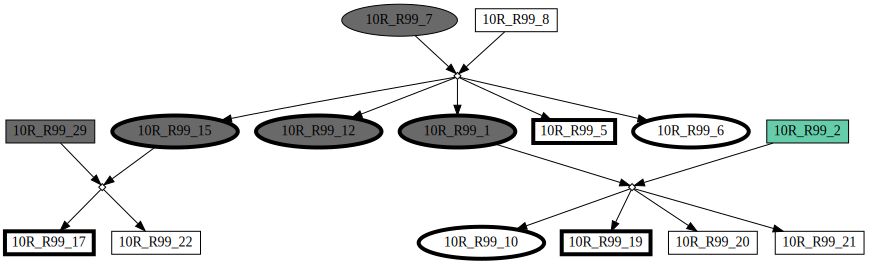

In [ ]:
plotped(ped[ped.fid=='10R_R99'])

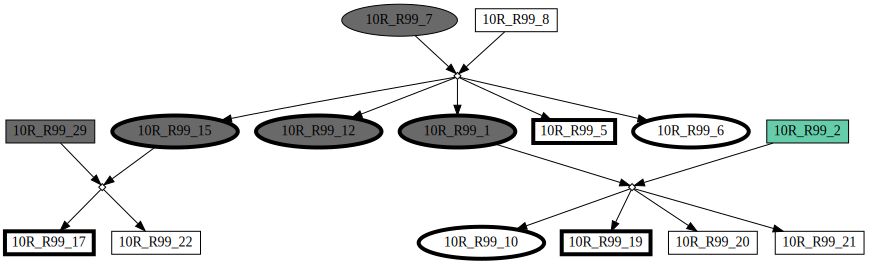

In [ ]:
plotped(ped[ped.fid=='10R_R99'])

### The pedigrees of complex families
4_649,3761,197,359,4_558,724,237,597,2,158

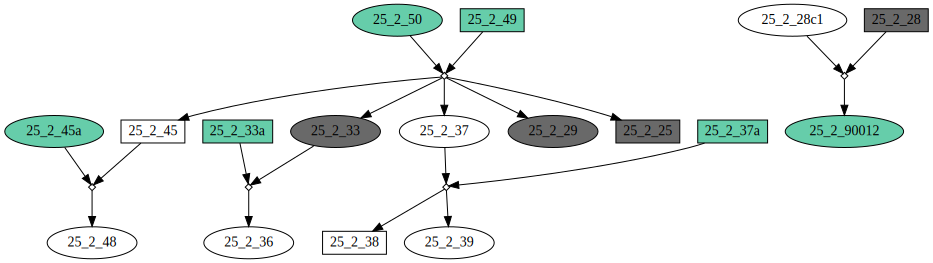

In [ ]:
plotped(fam17[fam17.fid =='25_2'])

In [ ]:
# big fam
for i in ['4_649','3761','197','359','4_558','724','237','597','2','158']:
    plotped(fam17[fam17.fid ==i],output=True,folder='data/bigest_fam/')

27_122, 10R_R47, 27_126,10R_R78,27_152,26_TCC,10R_R99,27_192,4_715,170

In [ ]:
lod_err_fam=['10R_R114','10R_R64','10R_R78','1227','1276','1280','1403','1517','1563','158','167','168','1858','197','1989','2','205','212','222','25_2','25_22','25_75','264','26_BCR','26_DXV','26_ERC','26_KS','26_NOA','27_131','27_231','27_40','27_55','27_70','28_4','2_13','2_17','2_19','2_20','333','336','350','359','3746','3761','411'
,'440','442','463','476','4_162','4_3741','4_393','4_501','4_515','4_558','4_589','4_595'
,'4_603','4_680','506','524','540','564','585','591','597','616','700','703','724','738','740','746','756'
,'785','7_113','8','800','827','8_64036','914','958']

In [ ]:
for i in lod_err_fam:
    plotped(fam17[fam17.fid ==i],output=True,folder='data/lod_err_fam/')

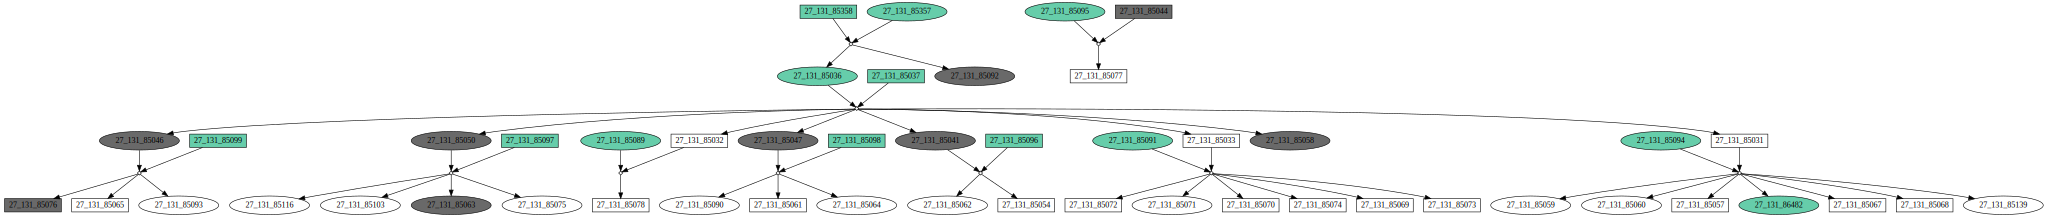

In [ ]:
plotped(fam17[fam17.fid =='27_131'])

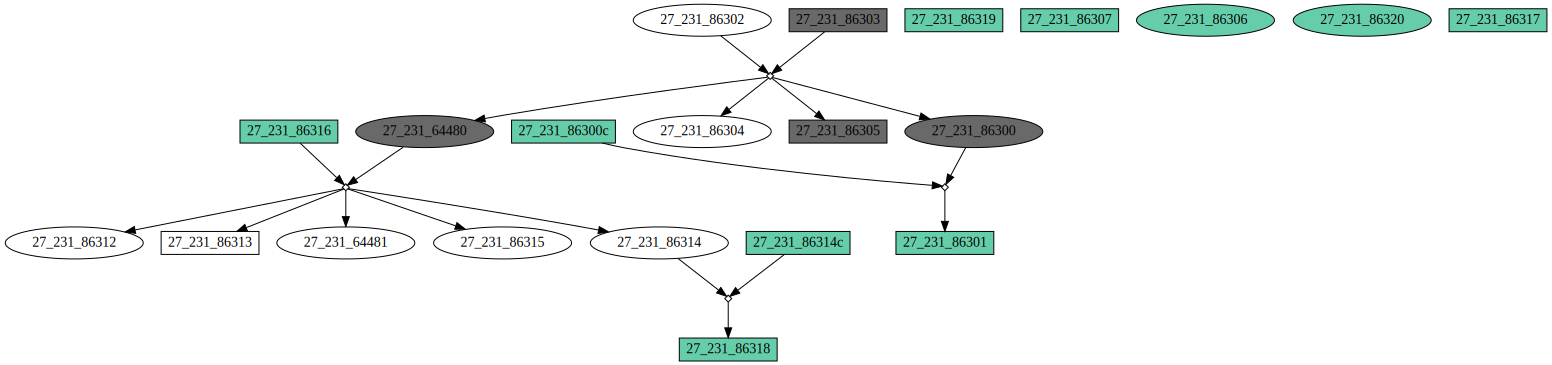

In [ ]:
plotped(fam17[fam17.fid =='27_231'])

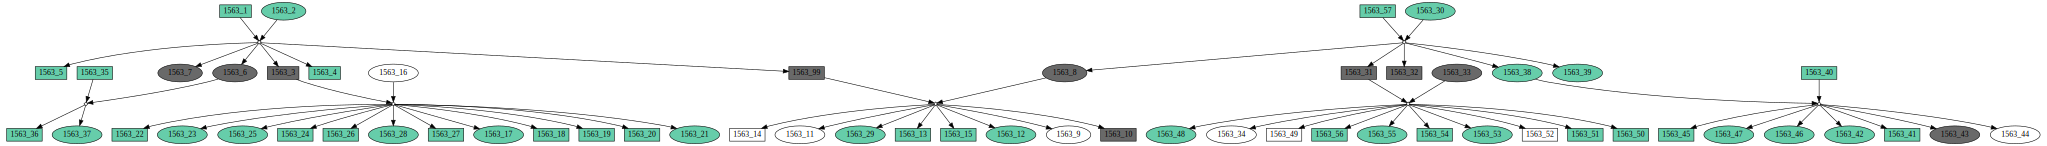

In [ ]:
plotped(fam17[fam17.fid ==lod_err_fam[8]])

In [ ]:
[plotped(all_fam[all_fam.fid ==i],output=True,folder='data/misspecified_gender/',format='pdf') for i in ['27_122', '10R_R47', '27_126','10R_R78','27_152','26_TCC','10R_R99','27_192','4_715','170']]

In [ ]:
fam_eg = pd.read_csv('data/fam.ped',header=None,names=['fid','iid','fathid','mothid','sex','ad'],sep='\t')

In [ ]:
fam_eg

,fid,iid,fathid,mothid,sex,ad
0,Fam,F4,P3,F1,1,1
1,Fam,F3,P3,F1,2,1
2,Fam,F2,P3,F1,2,1
3,Fam,F1,P1,P2,2,2
4,Fam,P3,0,0,1,2
5,Fam,P1,0,0,1,-9
6,Fam,P2,0,0,2,-9


In [ ]:
dot=plotped(fam_eg,output=True,folder='data/',format='pdf')

In [ ]:
print(dot.source)

digraph {
	F4 [shape=box fillcolor=white fontcolor=black height=0.3 regular=0 shape=box style=filled width=0.5]
	P3xF1 -> F4
	F3 [shape=box fillcolor=white fontcolor=black height=0.3 regular=0 shape=ellipse style=filled width=0.5]
	P3xF1 -> F3
	F2 [shape=box fillcolor=white fontcolor=black height=0.3 regular=0 shape=ellipse style=filled width=0.5]
	P3xF1 -> F2
	F1 [shape=box fillcolor=dimgrey fontcolor=black height=0.3 regular=0 shape=ellipse style=filled width=0.5]
	P1xP2 -> F1
	F1 -> P3xF1
	P3 [shape=box fillcolor=dimgrey fontcolor=black height=0.3 regular=0 shape=box style=filled width=0.5]
	P3 -> P3xF1
	P1 [shape=box fillcolor=aquamarine3 fontcolor=black height=0.3 regular=0 shape=box style=filled width=0.5]
	P1 -> P1xP2
	P2 [shape=box fillcolor=aquamarine3 fontcolor=black height=0.3 regular=0 shape=ellipse style=filled width=0.5]
	P2 -> P1xP2
	P1xP2 [label="" height=.1 shape=diamond width=.1]
	P3xF1 [label="" height=.1 shape=diamond width=.1]
}



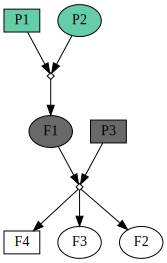

In [ ]:
plotped(fam_eg)

In [ ]:
fi = ped[ped.fid =='997']

In [ ]:
[plotped(new_twom_fam[new_twom_fam.fid ==i],output=True,folder='data/',format='pdf') for i in ['4_364','27_104','4_461','215','10R_R99']]

In [ ]:
new_twom_fam[new_twom_fam.fid =='10R_R99']

,fid,iid,fathid,mothid,sex,ad,vcf
754,10R_R99,10R_R99_15,10R_R99_8,10R_R99_7,2,2,True
759,10R_R99,10R_R99_12,10R_R99_8,10R_R99_7,2,2,True
762,10R_R99,10R_R99_1,10R_R99_8,10R_R99_7,2,2,True
763,10R_R99,10R_R99_5,10R_R99_8,10R_R99_7,1,1,True
764,10R_R99,10R_R99_6,10R_R99_8,10R_R99_7,2,1,True
765,10R_R99,10R_R99_10,10R_R99_2,10R_R99_1,2,1,True
766,10R_R99,10R_R99_17,10R_R99_29,10R_R99_15,1,1,True
767,10R_R99,10R_R99_19,10R_R99_2,10R_R99_1,1,1,True
14360,10R_R99,10R_R99_2,0,0,1,-9,False
14361,10R_R99,10R_R99_20,10R_R99_2,10R_R99_1,1,1,False


In [ ]:
dot=plotped(new_twom_fam[new_twom_fam.fid =='10R_R99'],output=True,folder='data/',format='pdf')

In [ ]:
print(dot.source)

digraph {
	"10R_R99_15" [shape=box fillcolor=dimgrey fontcolor=black height=0.3 regular=0 shape=ellipse style="filled,setlinewidth(4)" width=0.5]
	"10R_R99_8x10R_R99_7" -> "10R_R99_15"
	"10R_R99_15" -> "10R_R99_29x10R_R99_15"
	"10R_R99_12" [shape=box fillcolor=dimgrey fontcolor=black height=0.3 regular=0 shape=ellipse style="filled,setlinewidth(4)" width=0.5]
	"10R_R99_8x10R_R99_7" -> "10R_R99_12"
	"10R_R99_1" [shape=box fillcolor=dimgrey fontcolor=black height=0.3 regular=0 shape=ellipse style="filled,setlinewidth(4)" width=0.5]
	"10R_R99_8x10R_R99_7" -> "10R_R99_1"
	"10R_R99_1" -> "10R_R99_2x10R_R99_1"
	"10R_R99_5" [shape=box fillcolor=white fontcolor=black height=0.3 regular=0 shape=box style="filled,setlinewidth(4)" width=0.5]
	"10R_R99_8x10R_R99_7" -> "10R_R99_5"
	"10R_R99_5" -> "10R_R99_19x10R_R99_5"
	"10R_R99_6" [shape=box fillcolor=white fontcolor=black height=0.3 regular=0 shape=ellipse style="filled,setlinewidth(4)" width=0.5]
	"10R_R99_8x10R_R99_7" -> "10R_R99_6"
	"10R_R99_1

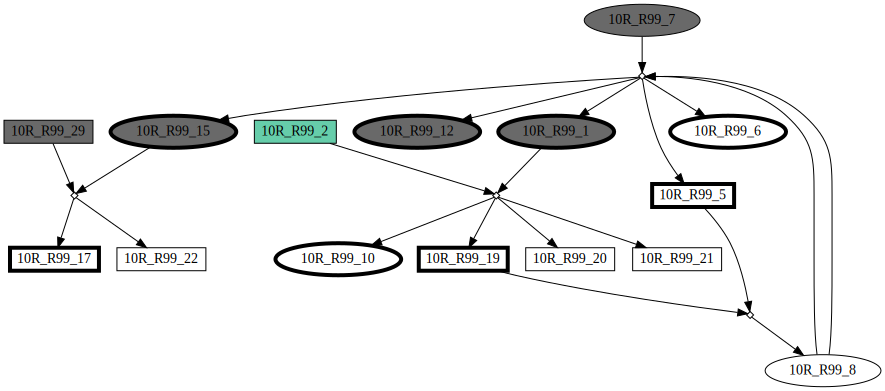

In [ ]:
dot

## Output plot

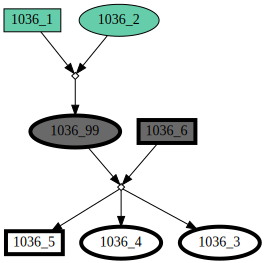

In [ ]:
plotped(ped[ped.fid =='1036'])

In [ ]:
trim_ped = ped[ped.trim==False]

array([[<AxesSubplot:title={'center':'before'}>,
        <AxesSubplot:title={'center':'after'}>]], dtype=object)

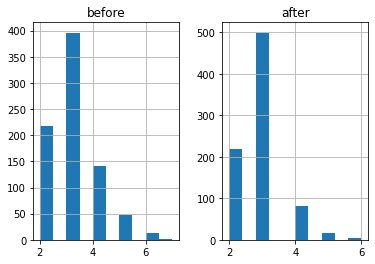

In [ ]:
trim_smry = pd.DataFrame([[ped.depth[ped.fid == i].max() for i in trim_ped.fid.unique()],[trim_ped.depth[trim_ped.fid == i].max() for i in trim_ped.fid.unique()]])
trim_smry = trim_smry.T
trim_smry.index = trim_ped.fid.unique()
trim_smry.columns = ['before','after']
trim_smry.hist()

In [ ]:
len(trim_smry.index[(trim_smry.before>3) & (trim_smry.after<4)])

103

In [ ]:
sum(trim_smry.before>4)

62

In [ ]:
sum(trim_smry.after<4)

717

In [ ]:
sum((tmp[0]<) & (tmp[1]<4))

0

In [ ]:
dots1 = [plotped(ped[ped.fid ==i],folder='data/ADfam_depthless4') for i in trim_smry.index[trim_smry.before<4]]

In [ ]:
dots2 = [plotped(ped[ped.fid ==i],folder='data/ADfam_trimless4/') for i in trim_smry.index[(trim_smry.before>3) & (trim_smry.after<4)]]

In [ ]:
dots3 = [plotped(ped[ped.fid ==i],folder='data/ADfam_trimmore4/') for i in trim_smry.index[trim_smry.after>3]]

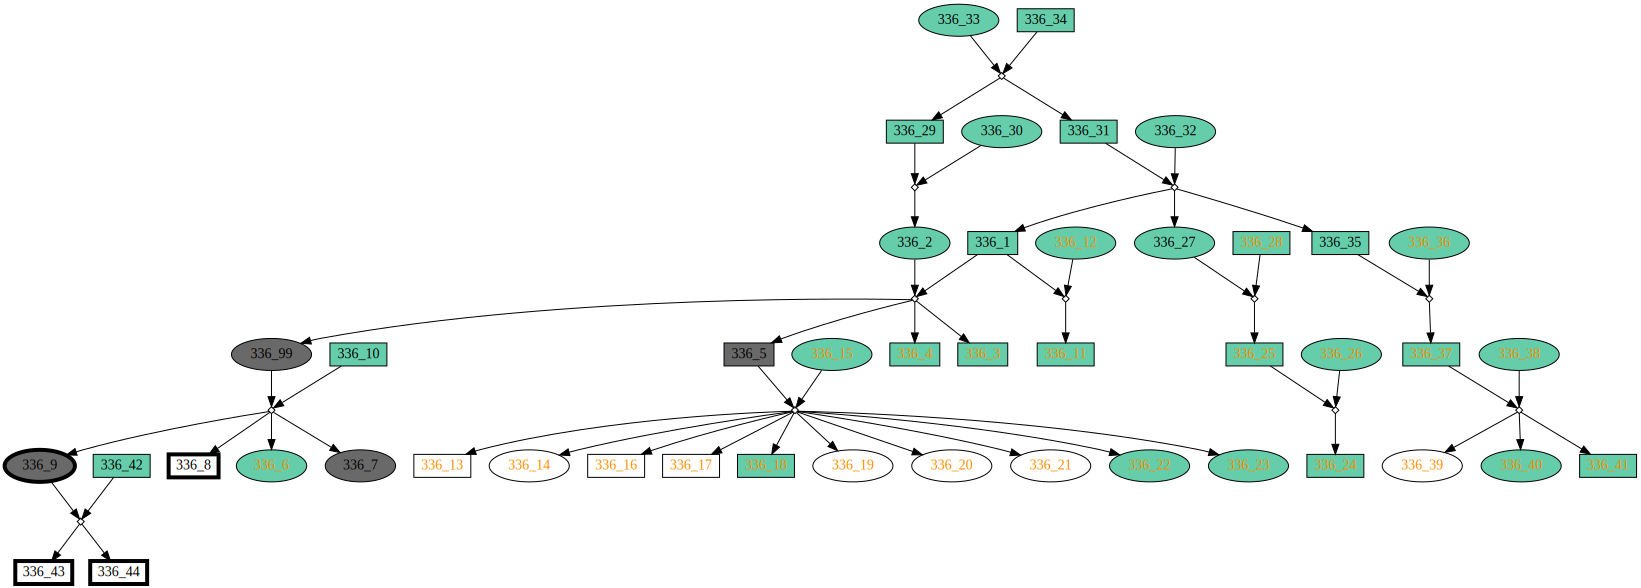

In [ ]:
plotped(ped[ped.fid =='336'])

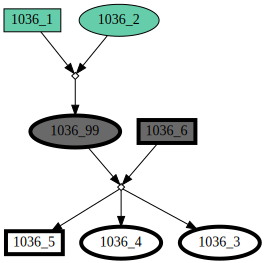

In [ ]:
dot